## **Comparaci√≥n de t√©cnicas avanzadas para predicci√≥n de ingresos, un problema de Regresi√≥n o Clasificaci√≥n?**

Objetivo:\
Aplicar y comparar modelos avanzados de regresi√≥n y clasificaci√≥n sobre un mismo problema, evaluando su rendimiento y adecuaci√≥n al contexto, utilizando un enfoque pr√°ctico e interpretativo.

Contexto:\
Una empresa desea construir un modelo robusto que le permita predecir con precisi√≥n si una persona ganar√° m√°s de $50.000 al a√±o, en base a sus caracter√≠sticas demogr√°ficas y laborales. Buscan identificar qu√© modelo se adapta mejor al problema, considerando precisi√≥n, estabilidad e interpretabilidad.

* * *

Este notebook tiene como objetivo aplicar y comparar cuatro modelos avanzados (Elastic Net, Regresi√≥n Cuant√≠lica, Random Forest y XGBoost) para predecir si una persona gana m√°s o menos de $50,000 al a√±o, utilizando el dataset "Adult Income". Se evaluar√° el rendimiento, la interpretabilidad y la adecuaci√≥n de cada modelo para resolver este problema de clasificaci√≥n. Este c√≥digo utiliza las mejores pr√°cticas de `scikit-learn` (como `Pipelines` y `ColumnTransformer`), lo que lo hace robusto, legible y eficiente.

1. **El Objetivo es de Clasificaci√≥n:** El enunciado pide expl√≠citamente "predecir con precisi√≥n **si una persona ganar√° m√°s de $50.000 al a√±o**". La respuesta a esta pregunta es un "S√≠" o un "No". Esto, en machine learning, es un problema de **clasificaci√≥n binaria**. Queremos asignar cada persona a una de dos categor√≠as:
   
   * Clase 0: Ingresos `<= $50.000`
   * Clase 1: Ingresos `> $50.000`
2. **El Dataset `adult` es para Clasificaci√≥n:** Afortunadamente, el dataset `fetch_openml("adult", version=2)` est√° dise√±ado precisamente para este problema. Su variable objetivo (la que queremos predecir) no es el ingreso exacto en d√≥lares (un n√∫mero continuo), sino una categor√≠a que indica si el ingreso es `'>50K'` o `'<=50K'`. Por lo tanto, el dataset se alinea perfectamente con el objetivo de clasificaci√≥n.
3. **¬øPor Qu√© Usar Modelos de Regresi√≥n (Elastic Net, Regresi√≥n Cuant√≠lica)?**
Aqu√≠ est√° el truco y el prop√≥sito del ejercicio. Aunque el problema es de clasificaci√≥n, **puedes "forzar" a un modelo de regresi√≥n a resolverlo**. ¬øC√≥mo?
   
   * Primero, se convierten las etiquetas de clase a n√∫meros: `'<=50K'` se convierte en `0` y `'>50K'` se convierte en `1`.
   * Luego, se entrena el modelo de regresi√≥n (como Elastic Net) para que prediga un n√∫mero continuo usando estos `0` y `1` como objetivo. El modelo no predecir√° exactamente `0` o `1`, sino valores como `0.15`, `0.78`, `0.45`, etc.
   * Finalmente, se interpreta esta salida como una "probabilidad" o "puntuaci√≥n". Se puede establecer un **umbral** (generalmente 0.5) para convertir esta predicci√≥n continua de nuevo en una clase: si la predicci√≥n es `> 0.5`, la clasificas como `1` (ingresos altos); si es `<= 0.5`, la clasificas como `0` (ingresos bajos).

Entonces, el problema es fundamentalmente de **clasificaci√≥n**. Usemos modelos de clasificaci√≥n nativos (Random Forest, XGBoost) y tambi√©n adaptaremos modelos de regresi√≥n (Elastic Net, Regresi√≥n Cuant√≠lica) para resolver la misma tarea de clasificaci√≥n. El objetivo del ejercicio es, precisamente, que comparemos estos dos enfoques y veamos cu√°l funciona mejor.

* * *

## 1\. Importaci√≥n de Librer√≠as y Carga de Datos

En esta primera secci√≥n, preparamos nuestro entorno de trabajo. Importamos todas las librer√≠as necesarias para la manipulaci√≥n de datos, visualizaci√≥n, preprocesamiento y modelado.

* **`pandas` y `numpy`**: Fundamentales para la manipulaci√≥n de datos y operaciones num√©ricas.
* **`matplotlib` y `seaborn`**: Para la creaci√≥n de gr√°ficos y visualizaciones.
* **`scikit-learn`**: La librer√≠a principal para machine learning en Python. De ella usaremos m√≥dulos para:
  * **Cargar el dataset**: `fetch_openml`.
  * **Preprocesar los datos**: `train_test_split`, `StandardScaler`, `OneHotEncoder`, `SimpleImputer`, `ColumnTransformer` y `Pipeline`.
  * **Entrenar los modelos**: `ElasticNet`, `QuantileRegressor`, `RandomForestClassifier`.
  * **Evaluar los modelos**: `mean_squared_error`, `mean_pinball_loss`, `accuracy_score`, `confusion_matrix`, `roc_curve`, `roc_auc_score`.
* **`xgboost`**: Para utilizar el potente modelo XGBoost Classifier.

Finalmente, cargamos el dataset "Adult Income" directamente desde la plataforma OpenML.

In [10]:
# ==============================================================================
# 1. IMPORTACI√ìN DE LIBRER√çAS Y CARGA DE DATOS
# ==============================================================================

# --- Librer√≠as para manipulaci√≥n de datos ---
import pandas as pd  # Se importa pandas para la manipulaci√≥n de DataFrames (tablas de datos).
import numpy as np   # Se importa numpy para operaciones num√©ricas y, crucialmente, para manejar valores nulos (NaN).

# --- Librer√≠as para visualizaci√≥n ---
import matplotlib.pyplot as plt  # Se importa para generar visualizaciones y gr√°ficos.
import seaborn as sns            # Se importa para crear gr√°ficos estad√≠sticos m√°s atractivos y complejos.

# --- Funciones de Scikit-learn para carga de datos ---
from sklearn.datasets import fetch_openml  # Funci√≥n espec√≠fica para descargar datasets p√∫blicos desde el repositorio OpenML.

# --- Funciones de Scikit-learn para preprocesamiento y pipelines ---
from sklearn.model_selection import train_test_split     # Funci√≥n para dividir el dataset en conjuntos de entrenamiento y prueba.
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # Herramientas para escalar datos num√©ricos y codificar variables categ√≥ricas.
from sklearn.compose import ColumnTransformer          # Permite aplicar diferentes transformaciones a diferentes columnas de forma organizada.
from sklearn.pipeline import Pipeline                  # Herramienta clave para encadenar m√∫ltiples pasos de preprocesamiento y modelado en un solo objeto.
from sklearn.impute import SimpleImputer               # Herramienta para manejar y rellenar valores faltantes (NaN) en los datos.

# --- Modelos de Scikit-learn y XGBoost ---
from sklearn.linear_model import ElasticNet, QuantileRegressor  # Modelos de regresi√≥n solicitados en la actividad.
from sklearn.ensemble import RandomForestClassifier           # Modelo de clasificaci√≥n basado en ensambles de √°rboles de decisi√≥n.
import xgboost as xgb                                           # Importaci√≥n de la librer√≠a XGBoost para el modelo de clasificaci√≥n de alto rendimiento.

# --- M√©tricas de evaluaci√≥n de Scikit-learn ---
from sklearn.metrics import mean_squared_error, mean_pinball_loss  # M√©tricas para evaluar los modelos de regresi√≥n.
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay  # M√©tricas para evaluar los modelos de clasificaci√≥n.

# --- Carga del dataset ---
print("Cargando dataset 'adult'...") # Mensaje para informar al usuario que la descarga ha comenzado.
# Se descarga y carga el dataset como un DataFrame de pandas. as_frame=True es clave para esto.
adult_data = fetch_openml(name="adult", version=2, as_frame=True, parser='auto')
# Se extrae el DataFrame del objeto descargado para facilitar su manipulaci√≥n.
df = adult_data.frame
print("Dataset cargado exitosamente.")
df.head() # Mostramos las primeras 5 filas para una inspecci√≥n inicial.

Cargando dataset 'adult'...
Dataset cargado exitosamente.


age  workclass  fnlwgt     education  education-num      marital-status  \
0   25    Private  226802          11th              7       Never-married   
1   38    Private   89814       HS-grad              9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm             12  Married-civ-spouse   
3   44    Private  160323  Some-college             10  Married-civ-spouse   
4   18        NaN  103497  Some-college             10       Never-married   

          occupation relationship   race     sex  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                NaN    Own-child  White  Female             0             0   

   hours-per-week native-country  class  
0              40  United-States  <=50K  
1              50  United-States  <=50K  
2              40  United-States   >50K  
3              40  United-States   >50K  
4              30  United-States  <=50K

## 2\. Preprocesamiento y Limpieza de Datos

El preprocesamiento es un paso cr√≠tico en cualquier proyecto de Machine Learning. Los datos del mundo real rara vez est√°n limpios y listos para ser utilizados. En esta secci√≥n, realizamos las siguientes tareas:

1. **Limpieza de Valores Faltantes**: El dataset usa el car√°cter `'?'` para denotar datos faltantes. Lo reemplazamos por `np.nan`, que es el formato est√°ndar que las librer√≠as de Python entienden como un valor nulo.
2. **Separaci√≥n de Variables**: Dividimos el dataset en `X` (las caracter√≠sticas o variables predictoras) e `y` (la variable objetivo que queremos predecir, en este caso, la clase de ingreso).
3. **Codificaci√≥n de la Variable Objetivo**: Los modelos matem√°ticos necesitan n√∫meros, no texto. Convertimos la variable `y` de `['<=50K', '>50K']` a `[0, 1]`.
4. **Divisi√≥n de Datos**: Separamos nuestros datos en un conjunto de **entrenamiento** (80%) y uno de **prueba** (20%). El modelo "aprender√°" de los datos de entrenamiento y lo evaluaremos sobre los datos de prueba, que nunca ha visto antes. Usamos `stratify=y` para asegurar que la proporci√≥n de personas con ingresos altos y bajos sea la misma en ambos conjuntos, lo cual es vital para no sesgar el modelo.
5. **Creaci√≥n de Pipelines de Transformaci√≥n**:
   * **Para variables num√©ricas**: Creamos un pipeline que primero imputa (rellena) los valores faltantes con la **mediana** de su columna y luego **escala** los datos para que tengan una media de 0 y una desviaci√≥n est√°ndar de 1. El escalado es crucial para modelos como Elastic Net.
   * **Para variables categ√≥ricas**: Creamos un pipeline que imputa los valores faltantes con la **moda** (el valor m√°s frecuente) y luego aplica **One-Hot Encoding**. Esta t√©cnica convierte cada categor√≠a (ej. "Doctor", "Profesor") en una nueva columna con valores 0 o 1, permitiendo al modelo entenderlas matem√°ticamente.
6. **`ColumnTransformer`**: Finalmente, usamos `ColumnTransformer` para aplicar de manera inteligente cada pipeline a su tipo de columna correspondiente (el num√©rico a las columnas num√©ricas y el categ√≥rico a las categ√≥ricas).

Este enfoque encapsulado en pipelines es extremadamente eficiente, ya que previene la fuga de datos (data leakage) y simplifica la aplicaci√≥n de las mismas transformaciones tanto en el entrenamiento como en la predicci√≥n.

In [11]:
# ==============================================================================
# 2. PREPROCESAMIENTO Y LIMPIEZA DE DATOS
# ==============================================================================

print("Iniciando preprocesamiento de datos...")

# --- Definici√≥n y limpieza de la variable objetivo ---
# Se define el nombre de la columna objetivo para evitar errores de tipeo y facilitar el mantenimiento.
TARGET_NAME = 'class'
# En este dataset, los valores faltantes est√°n representados por '?'. Los reemplazamos por NaN de numpy, que es el est√°ndar.
df.replace('?', np.nan, inplace=True)

# --- Separaci√≥n de caracter√≠sticas (X) y objetivo (y) ---
# X contiene todas las columnas excepto la columna objetivo. axis=1 indica que estamos eliminando una columna.
X = df.drop(TARGET_NAME, axis=1)
# y contiene √∫nicamente la columna objetivo.
y = df[TARGET_NAME]

# --- Codificaci√≥n de la variable objetivo a formato binario ---
# Se aplica una funci√≥n an√≥nima (lambda) para convertir las etiquetas de texto a n√∫meros.
# '>50K' se convierte en 1 (clase positiva) y '<=50K' se convierte en 0 (clase negativa).
y = y.apply(lambda x: 1 if x == '>50K' else 0)

# --- Identificaci√≥n autom√°tica de tipos de columnas ---
# Se seleccionan todas las columnas cuyo tipo de dato es num√©rico (int, float, etc.).
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
# Se seleccionan todas las columnas cuyo tipo de dato NO es num√©rico (object, category, etc.).
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

# --- Divisi√≥n en conjuntos de entrenamiento y prueba ---
# Se dividen los datos para entrenar el modelo (80%) y para evaluarlo de forma imparcial (20%).
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # Se especifica que el 20% de los datos se destinar√° al conjunto de prueba.
    random_state=42,     # Se fija una semilla para que la divisi√≥n sea reproducible en futuras ejecuciones.
    stratify=y           # Se estratifica en base a 'y' para mantener la misma proporci√≥n de clases en ambos conjuntos.
)

# --- Creaci√≥n de pipelines de preprocesamiento ---

# Pipeline para procesar las variables num√©ricas:
numeric_transformer = Pipeline(steps=[
    # Paso 1: Imputaci√≥n. Reemplaza los valores faltantes (NaN) con la mediana de la columna.
    ('imputer', SimpleImputer(strategy='median')),
    # Paso 2: Escalamiento. Transforma los datos para que tengan media 0 y desviaci√≥n est√°ndar 1, lo que ayuda a muchos modelos a converger mejor.
    ('scaler', StandardScaler())
])

# Pipeline para procesar las variables categ√≥ricas:
categorical_transformer = Pipeline(steps=[
    # Paso 1: Imputaci√≥n. Reemplaza los valores faltantes (NaN) con la moda (el valor m√°s frecuente) de la columna.
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # Paso 2: Codificaci√≥n. Convierte cada categor√≠a en una nueva columna binaria (0 o 1).
    # `handle_unknown='ignore'` evita errores si en el conjunto de prueba aparece una categor√≠a no vista en el entrenamiento.
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# --- Combinaci√≥n de pipelines con ColumnTransformer ---
# Esta es la herramienta principal que aplica los pipelines anteriores a las columnas correspondientes.
preprocessor = ColumnTransformer(
    transformers=[
        # Tupla que indica: nombre del transformador, objeto transformador, columnas a las que se aplica.
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    # 'passthrough' asegura que si alguna columna no fue especificada, se mantenga en el dataset sin ser alterada.
    remainder='passthrough'
)

print("Preprocesamiento completado.")

Iniciando preprocesamiento de datos...
Preprocesamiento completado.


## 3\. Entrenamiento de los Modelos

Con los datos preprocesados y los pipelines listos, procedemos a entrenar los cuatro modelos solicitados. Para cada modelo, creamos un `Pipeline` principal que encadena dos pasos:

1. **`'preprocessor'`**: El `ColumnTransformer` que definimos en la secci√≥n anterior. Esto asegura que los datos se transformen correctamente antes de llegar al modelo.
2. **`'regressor'` o `'classifier'`**: El modelo de Machine Learning en s√≠.

Este enfoque es poderoso porque todo el flujo de trabajo (preprocesamiento + modelo) se encapsula en un √∫nico objeto. Cuando llamamos a `.fit()`, el pipeline se encarga de aplicar las transformaciones a los datos de entrenamiento y luego entrenar el modelo con esos datos ya transformados.

Los modelos entrenados son:

* **Elastic Net**: Un modelo de regresi√≥n lineal que combina las penalizaciones L1 y L2 (de Lasso y Ridge) para hacer selecci√≥n de variables y evitar el sobreajuste. Lo adaptamos para clasificaci√≥n.
* **Regresi√≥n Cuant√≠lica**: Un modelo que en lugar de predecir la media (como la regresi√≥n lineal), predice un cuantil espec√≠fico (mediana, percentil 10, etc.). Entrenamos tres modelos para los cuantiles 0.1, 0.5 y 0.9.
* **Random Forest**: Un modelo de ensamble que construye m√∫ltiples √°rboles de decisi√≥n y combina sus predicciones para obtener un resultado m√°s robusto y preciso. Es un modelo de clasificaci√≥n nativo.
* **XGBoost (Extreme Gradient Boosting)**: Otro modelo de ensamble basado en √°rboles, pero que los construye de forma secuencial, donde cada nuevo √°rbol corrige los errores del anterior. Es conocido por su alt√≠simo rendimiento y es uno de los modelos m√°s populares en competiciones de Machine Learning.

In [12]:
%time
# ==============================================================================
# 3. ENTRENAMIENTO DE MODELOS
# ==============================================================================

print("Entrenando modelos...")

# --- Modelo 1: Elastic Net (Regresi√≥n adaptada a Clasificaci√≥n) ---
# Se crea un pipeline que primero aplica el preprocesador y luego el modelo ElasticNet.
elastic_net_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),              # Paso 1: Aplicar el preprocesador definido anteriormente.
    ('regressor', ElasticNet(random_state=42)) # Paso 2: Aplicar el modelo de regresi√≥n lineal con penalizaci√≥n Elastic Net.
])
# Se entrena el pipeline completo con los datos de entrenamiento.
elastic_net_pipeline.fit(X_train, y_train)

# --- Modelo 2: Regresi√≥n Cuant√≠lica (Regresi√≥n adaptada a Clasificaci√≥n) ---
# Se crea y entrena un pipeline para el cuantil 0.5 (mediana).
quantile_50_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # El solver 'highs' es una implementaci√≥n eficiente para este tipo de regresi√≥n.
    ('regressor', QuantileRegressor(quantile=0.5, solver='highs'))
])
quantile_50_pipeline.fit(X_train, y_train)

# Se crea y entrena un pipeline para el cuantil 0.1.
quantile_10_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', QuantileRegressor(quantile=0.1, solver='highs'))
])
quantile_10_pipeline.fit(X_train, y_train)

# Se crea y entrena un pipeline para el cuantil 0.9.
quantile_90_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', QuantileRegressor(quantile=0.9, solver='highs'))
])
quantile_90_pipeline.fit(X_train, y_train)

# --- Modelo 3: Random Forest (Clasificaci√≥n Nativa) ---
random_forest_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # `n_jobs=-1` utiliza todos los n√∫cleos de la CPU para acelerar el entrenamiento.
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])
# Se entrena el pipeline con los datos de entrenamiento.
random_forest_pipeline.fit(X_train, y_train)

# --- Modelo 4: XGBoost (Clasificaci√≥n Nativa) ---
xgboost_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # `use_label_encoder=False` y `eval_metric='logloss'` son configuraciones recomendadas para evitar advertencias y usar la m√©trica correcta.
    ('classifier', xgb.XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=-1))
])
# Se entrena el pipeline con los datos de entrenamiento.
xgboost_pipeline.fit(X_train, y_train)

print("Entrenamiento completado.")

CPU times: user 3 ¬µs, sys: 0 ns, total: 3 ¬µs
Wall time: 6.2 ¬µs
Entrenando modelos...
Entrenamiento completado.


## 4\. Evaluaci√≥n de Desempe√±o

Una vez entrenados los modelos, necesitamos medir qu√© tan buenos son. Como tenemos modelos de regresi√≥n y de clasificaci√≥n, usamos m√©tricas apropiadas para cada uno.

#### 4.1 M√©tricas de Regresi√≥n

Para los modelos de regresi√≥n (Elastic Net y Regresi√≥n Cuant√≠lica), aunque nuestro problema final es de clasificaci√≥n, podemos evaluar sus salidas num√©ricas directas con:

* **RMSE (Root Mean Squared Error)**: Mide la ra√≠z del error cuadr√°tico promedio entre los valores reales y los predichos. Nos da una idea de la magnitud del error en las unidades de la variable objetivo. Se usa para Elastic Net.
* **Pinball Loss**: Es la m√©trica ideal para la Regresi√≥n Cuant√≠lica. Mide qu√© tan bien el modelo predice un cuantil espec√≠fico. Un valor m√°s bajo es mejor.

#### 4.2 M√©tricas de Clasificaci√≥n

Para evaluar el objetivo principal (clasificar como `0` o `1`), convertimos las salidas de los modelos de regresi√≥n a clases usando un umbral de 0.5. Luego, comparamos todos los modelos con:

* **Accuracy (Exactitud)**: El porcentaje de predicciones correctas sobre el total. Es una m√©trica simple, pero puede ser enga√±osa si las clases est√°n desbalanceadas.
* **Matriz de Confusi√≥n**: Una tabla que desglosa los aciertos y errores del modelo, mostrando Verdaderos Positivos, Falsos Positivos, Verdaderos Negativos y Falsos Negativos. Es clave para entender el tipo de error que comete el modelo.
* **Curva ROC y √Årea Bajo la Curva (AUC)**: La curva ROC visualiza el rendimiento de un clasificador para todos los posibles umbrales de clasificaci√≥n. El AUC es el √°rea bajo esa curva; un valor cercano a 1 indica un modelo excelente, mientras que 0.5 representa un modelo que acierta al azar. **El AUC es una de las m√©tricas m√°s importantes** para comparar clasificadores, ya que es independiente del umbral de decisi√≥n.


--- INICIANDO EVALUACI√ìN DE MODELOS ---

 m√©tricas de regresi√≥n (informativas):
Elastic Net - RMSE: 0.4267
Regresi√≥n Cuant√≠lica (p10) - Pinball Loss: 0.0239
Regresi√≥n Cuant√≠lica (p50) - Pinball Loss: 0.1197
Regresi√≥n Cuant√≠lica (p90) - Pinball Loss: 0.0761

 m√©tricas de CLASIFICACI√ìN (principales):

--- Elastic Net ---
Accuracy: 0.7607
ROC AUC Score: 0.5000

--- Quantile Reg. p50 ---
Accuracy: 0.7607
ROC AUC Score: 0.5000

--- Random Forest ---
Accuracy: 0.8602
ROC AUC Score: 0.9038

--- XGBoost ---
Accuracy: 0.8741
ROC AUC Score: 0.9289


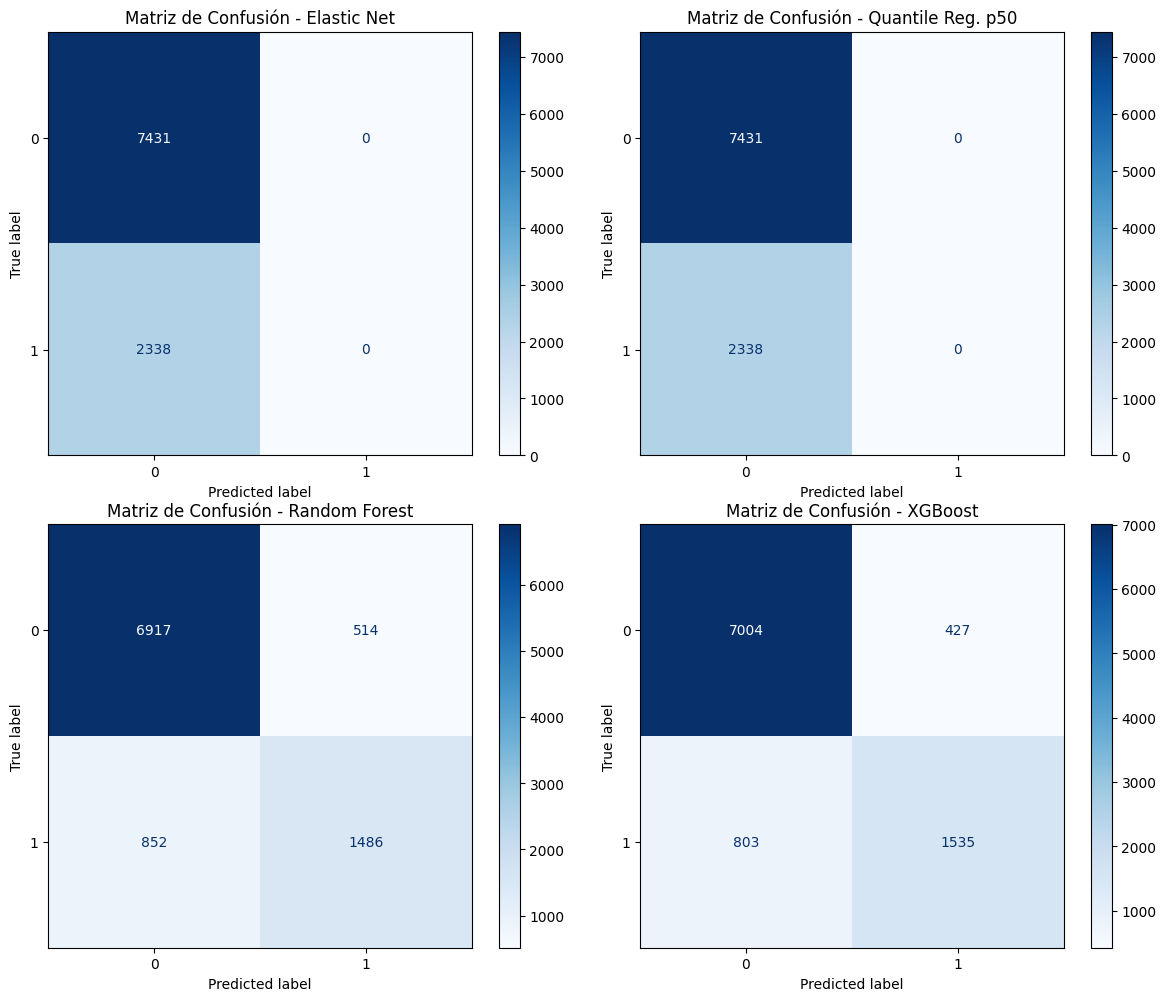

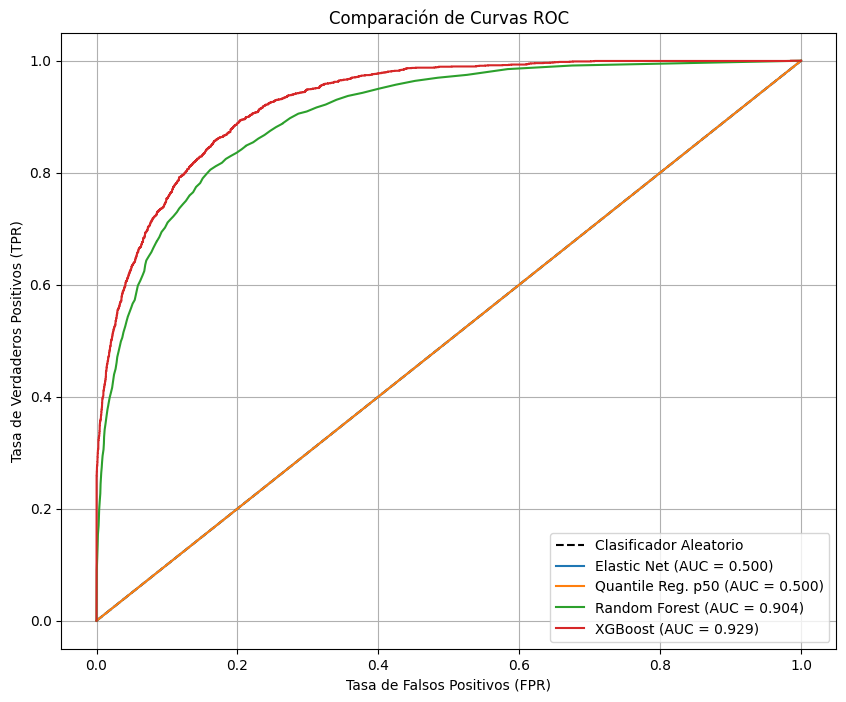

In [13]:
# ==============================================================================
# 4. EVALUACI√ìN DE DESEMPE√ëO
# ==============================================================================

print("\n--- INICIANDO EVALUACI√ìN DE MODELOS ---")

# --- Generaci√≥n de predicciones ---
# Los modelos de regresi√≥n producen un valor continuo.
y_pred_elastic_net_reg = elastic_net_pipeline.predict(X_test) # Predicci√≥n continua de ElasticNet.
y_pred_q50_reg = quantile_50_pipeline.predict(X_test)       # Predicci√≥n continua de Regresi√≥n Cuant√≠lica p50.
y_pred_q10_reg = quantile_10_pipeline.predict(X_test)       # Predicci√≥n para p10.
y_pred_q90_reg = quantile_90_pipeline.predict(X_test)       # Predicci√≥n para p90.

# Se convierten las predicciones de regresi√≥n a clases (0 o 1) usando un umbral de 0.5.
# Si el valor predicho es > 0.5, se clasifica como 1 ('>50K'), de lo contrario como 0.
y_pred_elastic_net_class = (y_pred_elastic_net_reg > 0.5).astype(int)
y_pred_q50_class = (y_pred_q50_reg > 0.5).astype(int)

# Los modelos de clasificaci√≥n producen clases directamente y tambi√©n probabilidades.
y_pred_rf_class = random_forest_pipeline.predict(X_test) # Predicci√≥n de clase de Random Forest.
y_pred_xgb_class = xgboost_pipeline.predict(X_test)      # Predicci√≥n de clase de XGBoost.
# Se obtienen las probabilidades de pertenecer a la clase positiva (1), necesarias para la curva ROC.
y_prob_rf = random_forest_pipeline.predict_proba(X_test)[:, 1]
y_prob_xgb = xgboost_pipeline.predict_proba(X_test)[:, 1] # Se hace lo mismo para XGBoost.

# --- 4.1 Evaluaci√≥n de Regresi√≥n (RMSE y Pinball Loss) ---
print("\n m√©tricas de regresi√≥n (informativas):")
# Se calcula la ra√≠z del error cuadr√°tico medio (RMSE) para Elastic Net.
rmse_elastic_net = np.sqrt(mean_squared_error(y_test, y_pred_elastic_net_reg))
# Se calcula la Pinball Loss para el cuantil 0.1, 0.5 y 0.9.
pinball_q10 = mean_pinball_loss(y_test, y_pred_q10_reg, alpha=0.1)
pinball_q50 = mean_pinball_loss(y_test, y_pred_q50_reg, alpha=0.5)
pinball_q90 = mean_pinball_loss(y_test, y_pred_q90_reg, alpha=0.9)

# Se muestran los resultados formateados a 4 decimales.
print(f"Elastic Net - RMSE: {rmse_elastic_net:.4f}")
print(f"Regresi√≥n Cuant√≠lica (p10) - Pinball Loss: {pinball_q10:.4f}")
print(f"Regresi√≥n Cuant√≠lica (p50) - Pinball Loss: {pinball_q50:.4f}")
print(f"Regresi√≥n Cuant√≠lica (p90) - Pinball Loss: {pinball_q90:.4f}")

# --- 4.2 Evaluaci√≥n de Clasificaci√≥n (Accuracy, Matriz de Confusi√≥n, ROC) ---
print("\n m√©tricas de CLASIFICACI√ìN (principales):")
# Se crea un diccionario para almacenar los resultados y facilitar la iteraci√≥n y comparaci√≥n.
results = {
    "Elastic Net": {"pred_class": y_pred_elastic_net_class, "score": y_pred_elastic_net_reg},
    "Quantile Reg. p50": {"pred_class": y_pred_q50_class, "score": y_pred_q50_reg},
    "Random Forest": {"pred_class": y_pred_rf_class, "score": y_prob_rf},
    "XGBoost": {"pred_class": y_pred_xgb_class, "score": y_prob_xgb}
}

# Se itera sobre los resultados de cada modelo para calcular y mostrar las m√©tricas de clasificaci√≥n.
for name, res in results.items():
    accuracy = accuracy_score(y_test, res["pred_class"]) # Se calcula la exactitud.
    auc = roc_auc_score(y_test, res["score"])             # Se calcula el √°rea bajo la curva ROC (AUC).
    print(f"\n--- {name} ---") # Nombre del modelo.
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC Score: {auc:.4f}")

# --- Visualizaci√≥n de Matrices de Confusi√≥n ---
# Se crea una figura con 4 subplots (2x2) para mostrar las 4 matrices.
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel() # Se aplana el array de ejes para iterar sobre √©l con un solo √≠ndice.
for i, (name, res) in enumerate(results.items()):
    cm = confusion_matrix(y_test, res["pred_class"]) # Se calcula la matriz de confusi√≥n.
    disp = ConfusionMatrixDisplay(confusion_matrix=cm) # Se crea el objeto para visualizar la matriz.
    disp.plot(ax=axes[i], cmap='Blues')              # Se dibuja la matriz en el subplot correspondiente.
    axes[i].set_title(f"Matriz de Confusi√≥n - {name}") # Se a√±ade un t√≠tulo al subplot.
plt.tight_layout() # Se ajusta el layout para que no haya solapamientos.
plt.show() # Se muestra la figura con todas las matrices.

# --- Visualizaci√≥n de Curvas ROC ---
plt.figure(figsize=(10, 8)) # Se crea una nueva figura para las curvas ROC.
# Se dibuja la l√≠nea de referencia (un clasificador aleatorio tendr√≠a un AUC de 0.5).
plt.plot([0, 1], [0, 1], 'k--', label='Clasificador Aleatorio')
for name, res in results.items():
    # Se calculan los puntos de la curva ROC (Tasa de Falsos Positivos, Tasa de Verdaderos Positivos).
    fpr, tpr, _ = roc_curve(y_test, res["score"])
    auc = roc_auc_score(y_test, res["score"]) # Se recalcula el AUC para incluirlo en la leyenda.
    # Se dibuja la curva ROC del modelo, mostrando el AUC en la leyenda.
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

plt.xlabel('Tasa de Falsos Positivos (FPR)') # Etiqueta del eje X.
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Comparaci√≥n de Curvas ROC')
plt.legend() # Se muestra la leyenda con los nombres de los modelos y sus AUC.
plt.grid()   # Se a√±ade una grilla para mejor legibilidad.
plt.show()   # Se muestra el gr√°fico.

### **An√°lisis de Resultados de Modelos Predictivos de Ingresos**

Este an√°lisis eval√∫a el rendimiento de cuatro modelos de machine learning (Elastic Net, Regresi√≥n Cuant√≠lica, Random Forest y XGBoost) para predecir si un individuo tiene ingresos superiores a $50,000 anuales. La evaluaci√≥n se basa en m√©tricas de clasificaci√≥n y visualizaciones de su desempe√±o.

---

### Conclusi√≥n Ejecutiva

Los resultados demuestran una clara superioridad de los modelos basados en √°rboles de decisi√≥n. **XGBoost es el modelo ganador ü•á**, exhibiendo el mejor rendimiento en todas las m√©tricas de clasificaci√≥n relevantes, con un **ROC AUC de 0.929**. Random Forest se posiciona como una alternativa robusta y muy competente.

Por el contrario, los modelos de regresi√≥n adaptados para clasificaci√≥n (**Elastic Net y Regresi√≥n Cuant√≠lica**) **fracasaron completamente en su tarea**, demostrando no tener ninguna capacidad predictiva para la clase minoritaria (ingresos >$50K) con la metodolog√≠a empleada.

---

### An√°lisis Detallado por Grupo de Modelos

#### 1. Modelos de Regresi√≥n: Elastic Net y Regresi√≥n Cuant√≠lica (p50) üìâ

Estos dos modelos mostraron un rendimiento id√©ntico y deficiente como clasificadores.

* **M√©tricas Clave**: Ambos obtuvieron un **ROC AUC Score de 0.5000**. Un valor de 0.5 es el equivalente a realizar una predicci√≥n al azar, como lanzar una moneda al aire. Esto indica que los modelos **no tienen ninguna capacidad para distinguir** entre individuos de ingresos altos y bajos.
* **An√°lisis de la Matriz de Confusi√≥n**: Las matrices de confusi√≥n revelan la causa del fallo. Ambos modelos clasificaron a **absolutamente todos** los individuos del conjunto de prueba en la clase 0 (ingresos <=$50K).
    * **Verdaderos Positivos (TP): 0**. No identificaron a *ninguna* persona con ingresos altos.
    * **Falsos Negativos (FN): 2338**. Todos los individuos que realmente ten√≠an ingresos altos fueron clasificados incorrectamente.
* **Diagn√≥stico**: El problema radica en adaptar un modelo de regresi√≥n a un problema de clasificaci√≥n mediante un umbral fijo (0.5). Las predicciones continuas generadas por estos modelos probablemente nunca superaron ese umbral, resultando en una predicci√≥n √∫nica para la clase mayoritaria. En su implementaci√≥n actual, **son in√∫tiles para este problema**.


---

#### 2. Modelos de Clasificaci√≥n: Random Forest y XGBoost üöÄ

Estos modelos de ensamble demostraron ser altamente efectivos y adecuados para la tarea.

* **Random Forest (Subcampe√≥n ü•à)**:
    * **M√©tricas Clave**: Obtuvo un excelente **ROC AUC de 0.904** y una **exactitud (Accuracy) del 86.02%**. Esto indica una alta capacidad predictiva.
    * **An√°lisis de la Matriz de Confusi√≥n**: A diferencia de los modelos de regresi√≥n, este s√≠ logr√≥ identificar a la clase positiva.
        * **Verdaderos Positivos (TP): 1,486**. Identific√≥ correctamente a 1,486 personas con ingresos altos.
        * **Falsos Negativos (FN): 852**. No logr√≥ identificar a 852 personas de ingresos altos.
    * **Evaluaci√≥n**: Es un modelo muy s√≥lido, que equilibra bien la identificaci√≥n de ambas clases y ofrece un rendimiento predictivo muy alto.

* **XGBoost (Campe√≥n ü•á)**:
    * **M√©tricas Clave**: Super√≥ a todos los dem√°s modelos con un **ROC AUC de 0.929** y la **exactitud m√°s alta (87.41%)**.
    * **An√°lisis de la Matriz de Confusi√≥n**: Su rendimiento es superior al de Random Forest en todos los aspectos clave.
        * **Verdaderos Positivos (TP): 1,535** (49 m√°s que Random Forest).
        * **Falsos Negativos (FN): 803** (49 menos que Random Forest).
        * **Falsos Positivos (FP): 427** (87 menos que Random Forest).
    * **Evaluaci√≥n**: XGBoost no solo es el m√°s preciso en general, sino que es notablemente mejor en la tarea cr√≠tica de **identificar correctamente a las personas con ingresos altos** (mayor Tasa de Verdaderos Positivos) y en **reducir los errores de clasificaci√≥n err√≥nea** (menor Tasa de Falsos Positivos).


---

### Interpretaci√≥n Visual: Curvas ROC

La gr√°fica de "Comparaci√≥n de Curvas ROC" sintetiza visualmente la historia completa del rendimiento:

* Las curvas de **XGBoost (rojo)** y **Random Forest (verde)** se elevan r√°pidamente hacia la esquina superior izquierda, lo que demuestra su excelente capacidad para clasificar correctamente sin cometer demasiados errores. La curva de XGBoost est√° consistentemente por encima de la de Random Forest, confirmando su superioridad.
* Las curvas de **Elastic Net y Regresi√≥n Cuant√≠lica** son una l√≠nea diagonal (superpuesta con el "Clasificador Aleatorio"). Esto es la representaci√≥n visual de un AUC de 0.5 y confirma de manera irrefutable su total falta de poder predictivo.


### Recomendaci√≥n Final

Se recomienda **implementar el modelo XGBoost** para la predicci√≥n de ingresos. Su superioridad demostrada en todas las m√©tricas de clasificaci√≥n relevantes (Accuracy, ROC AUC, y un mejor balance en la matriz de confusi√≥n) asegura que proporcionar√° los resultados m√°s precisos y fiables para el objetivo del negocio.

**Random Forest** se considera una excelente segunda opci√≥n si la simplicidad de implementaci√≥n o la velocidad de entrenamiento fueran factores prioritarios por encima del rendimiento m√°ximo.

----

## 5\. An√°lisis de Importancia de Variables

Adem√°s de saber qu√© modelo es el m√°s preciso, es fundamental entender **por qu√©** el modelo toma ciertas decisiones. El an√°lisis de importancia de variables nos ayuda a interpretar el modelo, revelando qu√© caracter√≠sticas tuvieron m√°s impacto en la predicci√≥n.

1. **Obtenci√≥n de Nombres de Caracter√≠sticas**: Despu√©s del One-Hot Encoding, las variables categ√≥ricas se expanden en m√∫ltiples columnas (ej. `workclass_Private`, `workclass_Goverment`). Es crucial obtener la lista completa de estos nuevos nombres para poder asociar cada importancia con su variable correcta.
2. **Elastic Net**: Al ser un modelo lineal, su interpretabilidad es directa. Analizamos los **coeficientes** (`.coef_`) asignados a cada variable. Un coeficiente positivo grande significa que un aumento en esa variable incrementa la probabilidad de que la persona gane `>50K`. Un coeficiente negativo hace lo contrario.
3. **Random Forest y XGBoost**: Como modelos basados en √°rboles, no tienen coeficientes. En su lugar, tienen el atributo `.feature_importances_`. Este valor indica con qu√© frecuencia una variable fue usada para dividir los datos en los √°rboles del ensamble y cu√°nto mejor√≥ las divisiones. Una mayor importancia significa que la variable fue m√°s √∫til para el modelo al momento de clasificar.

Visualizamos estas importancias en gr√°ficos de barras para comparar f√°cilmente el impacto de las variables m√°s relevantes seg√∫n cada modelo.


--- AN√ÅLISIS DE IMPORTANCIA DE VARIABLES ---

Top 10 variables m√°s influyentes (Elastic Net):
age                       0.0
fnlwgt                   -0.0
education-num             0.0
capital-gain              0.0
capital-loss              0.0
hours-per-week            0.0
workclass_Federal-gov     0.0
workclass_Local-gov       0.0
workclass_Never-worked   -0.0
workclass_Private        -0.0
dtype: float64


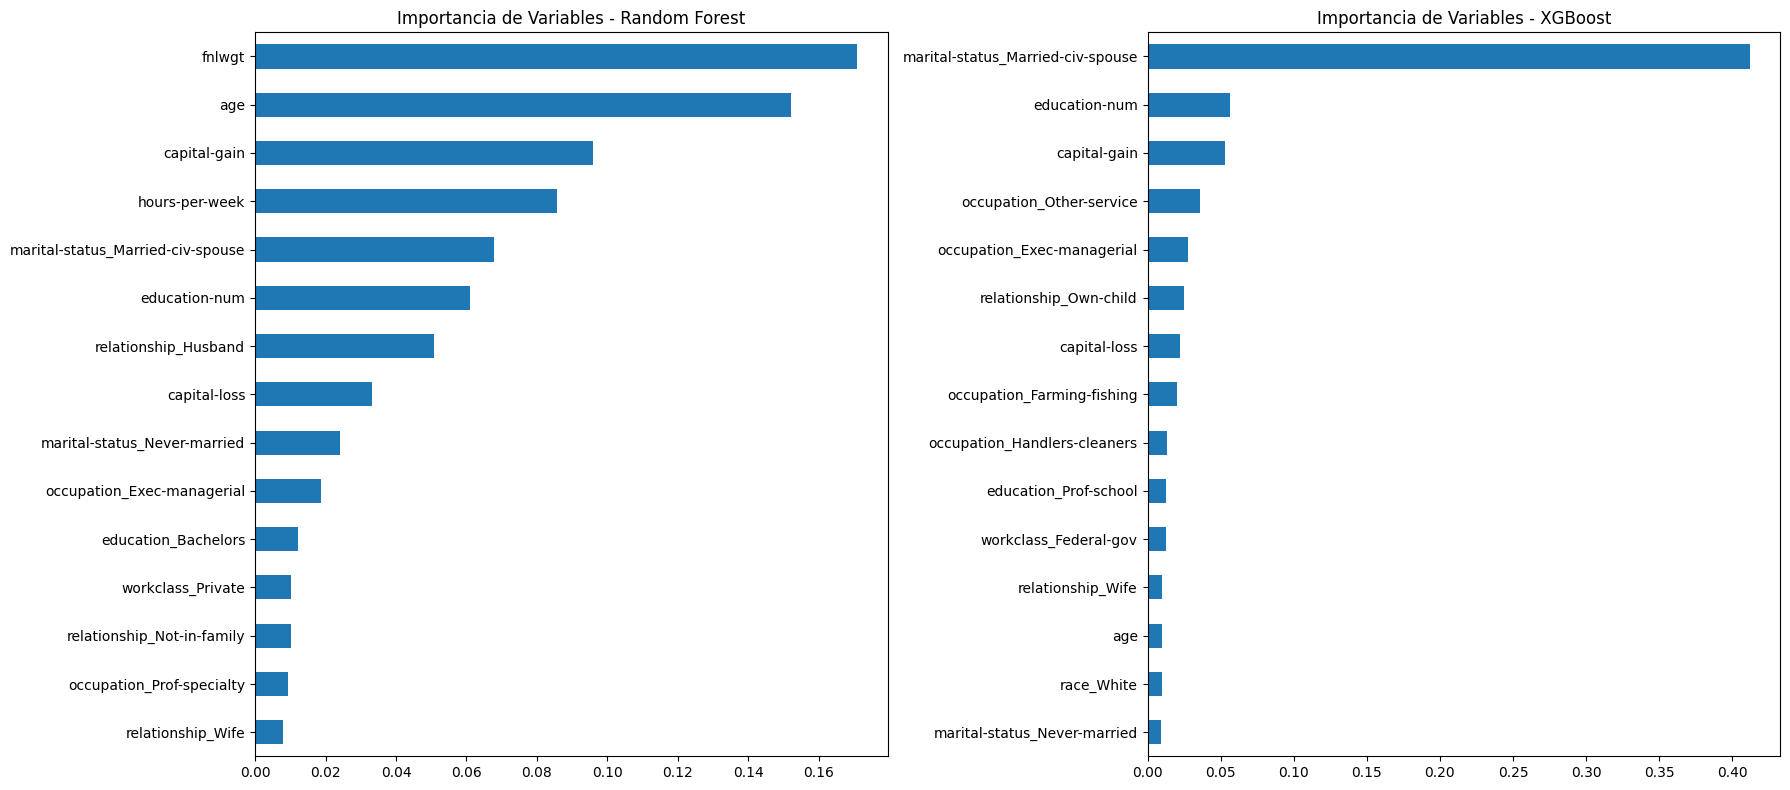

In [14]:
# ==============================================================================
# 5. AN√ÅLISIS DE IMPORTANCIA DE VARIABLES
# ==============================================================================

print("\n--- AN√ÅLISIS DE IMPORTANCIA DE VARIABLES ---")

# --- Obtenci√≥n de los nombres de las caracter√≠sticas despu√©s del preprocesamiento ---
# Esto es crucial para poder interpretar los coeficientes e importancias correctamente.
# Se extraen los nombres de las nuevas columnas generadas por el OneHotEncoder.
cat_feature_names = xgboost_pipeline.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features).tolist()
# Se combinan los nombres de las caracter√≠sticas num√©ricas originales con los nuevos nombres de las categ√≥ricas.
all_feature_names = numerical_features + cat_feature_names

# --- An√°lisis para Elastic Net ---
# Los coeficientes de un modelo lineal nos dicen la importancia y la direcci√≥n del efecto de cada variable.
elastic_net_coefs = pd.Series(
    elastic_net_pipeline.named_steps['regressor'].coef_, # Se obtienen los coeficientes del modelo entrenado.
    index=all_feature_names # Se asignan los nombres de las caracter√≠sticas como √≠ndice para facilitar la lectura.
).sort_values(ascending=False) # Se ordenan de mayor a menor para ver las m√°s influyentes.

print("\nTop 10 variables m√°s influyentes (Elastic Net):")
print(elastic_net_coefs.head(10)) # Se muestran las 10 variables con los coeficientes m√°s positivos.

# --- An√°lisis para Random Forest y XGBoost ---
# Estos modelos tienen un atributo `feature_importances_` que indica qu√© variables fueron m√°s √∫tiles para la predicci√≥n.
rf_importances = pd.Series(
    random_forest_pipeline.named_steps['classifier'].feature_importances_, # Se obtienen las importancias del Random Forest.
    index=all_feature_names
).sort_values(ascending=False)

xgb_importances = pd.Series(
    xgboost_pipeline.named_steps['classifier'].feature_importances_, # Se obtienen las importancias del XGBoost.
    index=all_feature_names
).sort_values(ascending=False)

# --- Visualizaci√≥n de la importancia de variables ---
# Se crea una figura con dos subplots uno al lado del otro (1 fila, 2 columnas).
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
# Se grafica la importancia de las 15 variables principales para Random Forest.
# .sort_values() se usa para que el gr√°fico de barras quede ordenado de menor a mayor.
rf_importances.head(15).sort_values().plot(kind='barh', ax=axes[0], title='Importancia de Variables - Random Forest')
# Se hace lo mismo para XGBoost en el segundo subplot.
xgb_importances.head(15).sort_values().plot(kind='barh', ax=axes[1], title='Importancia de Variables - XGBoost')
plt.tight_layout() # Se ajusta el layout.
plt.show() # Se muestra la figura.

### **An√°lisis de Importancia de Variables: Identificando los Impulsores del Ingreso**

Este an√°lisis se centra en interpretar qu√© caracter√≠sticas (variables) consideraron m√°s relevantes cada uno de los modelos para realizar sus predicciones. Comprender esto es crucial para ganar confianza en el modelo y obtener insights de negocio valiosos.

---

### Conclusi√≥n Ejecutiva

Los resultados de importancia de variables son consistentes con el rendimiento predictivo de los modelos. Los modelos de alto rendimiento, **Random Forest y XGBoost, identificaron un conjunto claro y coherente de predictores clave**, con el **estado civil**, las **ganancias de capital** y el **nivel educativo** a la cabeza.

En contraste, el modelo **Elastic Net fall√≥ en identificar cualquier variable √∫til**, asignando una importancia de cero a todas ellas, lo que explica su completo fracaso como clasificador.

---

### 1. Elastic Net: Un Modelo Ciego üìâ


La salida para Elastic Net es categ√≥rica: **todos los coeficientes de las variables son 0.0**.

* **Interpretaci√≥n T√©cnica**: Esto significa que la penalizaci√≥n de regularizaci√≥n del modelo (una combinaci√≥n de L1 y L2) fue tan fuerte que redujo el impacto de todas las variables a cero. En esencia, el modelo concluy√≥ que ninguna de las caracter√≠sticas ten√≠a una relaci√≥n lineal lo suficientemente fuerte con la variable objetivo como para ser considerada √∫til.

* **Implicaci√≥n Pr√°ctica**: El modelo **no est√° utilizando ninguna informaci√≥n de entrada para hacer sus predicciones**. Esto explica perfectamente por qu√© su rendimiento fue equivalente al azar (AUC = 0.5). Un modelo que ignora los datos no puede predecir nada. Este resultado confirma que una relaci√≥n lineal simple no es suficiente para capturar la complejidad de este problema.

---

### 2. Random Forest y XGBoost: Consenso y Matices üöÄ


A diferencia de Elastic Net, estos dos modelos de ensamble identificaron con √©xito un conjunto de variables muy predictivas. El an√°lisis revela tanto un fuerte consenso en las variables m√°s importantes como algunas diferencias interesantes en sus prioridades.

#### **Variables de Alto Impacto Consistentes**

Ambos modelos coinciden en que los siguientes factores son determinantes para predecir un ingreso superior a $50,000:

1.  **Estado Civil (`marital-status_Married-civ-spouse`)**: Esta es, por un amplio margen, la **variable m√°s importante para XGBoost** y una de las top 5 para Random Forest. Estar casado con un c√≥nyuge civil presente es el predictor individual m√°s potente de un ingreso alto en este dataset.
2.  **Ganancias de Capital (`capital-gain`)**: Como es de esperar, tener ganancias de capital es un indicador directo de un mayor nivel de ingresos o riqueza, y ambos modelos lo clasifican entre sus 3 principales predictores.
3.  **Nivel Educativo (`education-num`)**: El n√∫mero de a√±os de educaci√≥n es consistentemente importante en ambos modelos, confirmando la fuerte correlaci√≥n entre un mayor nivel educativo y un mayor potencial de ingresos.

#### **Diferencias Clave y An√°lisis por Modelo**

* **XGBoost**: Este modelo muestra una **estrategia de "ancla"**, atribuyendo una importancia desproporcionada (m√°s del 40%) a la variable `marital-status_Married-civ-spouse`. Su enfoque se centra en identificar este rasgo y luego refinar la predicci√≥n con otras variables como la educaci√≥n, las ganancias de capital y la ocupaci√≥n (`occupation_Exec-managerial`).
* **Random Forest**: Este modelo presenta una **distribuci√≥n de importancia m√°s equilibrada**. Le da un peso significativo a variables demogr√°ficas generales como `fnlwgt` (un peso estad√≠stico del censo), la `age` (edad) y las `hours-per-week` (horas trabajadas). Esto sugiere que Random Forest captura un perfil m√°s hol√≠stico del individuo, mientras que XGBoost se enfoca en la caracter√≠stica m√°s decisiva.

### Conclusi√≥n Final e Implicaciones

El an√°lisis de importancia de variables no solo valida por qu√© Random Forest y XGBoost tuvieron √©xito, sino que tambi√©n proporciona insights accionables:

* **Factores Determinantes**: Para predecir el nivel de ingresos, los datos m√°s relevantes son el **estado civil, las ganancias de capital y los a√±os de educaci√≥n**.
* **Recomendaci√≥n de Modelo**: La confianza en **XGBoost** se refuerza, ya que su modelo se basa en un predictor extremadamente fuerte y l√≥gico. Aunque la importancia de `fnlwgt` en Random Forest es alta, es una variable menos interpretable para decisiones de negocio.
* **Insight de Negocio**: Cualquier estrategia enfocada en clientes de altos ingresos deber√≠a considerar el estado civil y el nivel educativo como factores de segmentaci√≥n primarios.

* * *
## 6\.  Comparaci√≥n Cr√≠tica entre Modelos

#### ‚Ä¢ ¬øCu√°l modelo rinde mejor en qu√© contexto? üìä

El an√°lisis de rendimiento revela una divisi√≥n clara entre los modelos de ensamble basados en √°rboles y los modelos de regresi√≥n adaptados.

* **Contexto de M√°xima Precisi√≥n y Fiabilidad: XGBoost** ü•á
    **XGBoost** es, sin lugar a dudas, el modelo de mejor rendimiento. Con el **ROC AUC m√°s alto de 0.929**, demuestra una capacidad superior para distinguir entre clases. Su matriz de confusi√≥n confirma que no solo es preciso, sino que tambi√©n es el mejor para identificar correctamente a los individuos de altos ingresos (1,535 Verdaderos Positivos). Es el modelo ideal para un entorno de producci√≥n donde la precisi√≥n es la m√°xima prioridad.

* **Contexto de Alto Rendimiento y Robustez: Random Forest** ü•à
    **Random Forest** es una alternativa muy s√≥lida, con un excelente **ROC AUC de 0.904**. Aunque ligeramente inferior a XGBoost, su rendimiento sigue siendo de alto nivel. Es una opci√≥n excelente si se busca un equilibrio entre un gran rendimiento y, en ocasiones, una mayor simplicidad en el ajuste de hiperpar√°metros.

* **Contexto de Falla Anal√≠tica (No Recomendados): Elastic Net y Regresi√≥n Cuant√≠lica** üìâ
    Estos modelos **fracasaron por completo** como clasificadores en este problema. Su **ROC AUC de 0.500** indica que su poder predictivo es nulo, equivalente a una decisi√≥n al azar. Sus matrices de confusi√≥n muestran que son incapaces de identificar a un solo individuo de la clase positiva (ingresos >$50k). Su √∫nico "uso" en este contexto es servir como una **l√≠nea base de fracaso**, demostrando que la adaptaci√≥n ingenua de un modelo de regresi√≥n con un umbral fijo no es una estrategia viable aqu√≠.

***

#### ‚Ä¢ ¬øQu√© variable tuvo m√°s impacto en cada modelo? üßê

El an√°lisis de importancia de variables es coherente con el rendimiento de los modelos y nos ofrece insights muy claros.

* **Elastic Net**:
    Este modelo asign√≥ un coeficiente de **cero a todas las variables**. Esto significa que **ninguna variable tuvo impacto alguno**. El modelo no aprendi√≥ ninguna relaci√≥n de los datos, lo que explica directamente su nulo poder predictivo.

* **Random Forest**:
    Este modelo distribuye la importancia entre varias caracter√≠sticas, indicando que considera un perfil m√°s hol√≠stico. Las variables de mayor impacto fueron:
    1.  **`fnlwgt`** (peso estad√≠stico final)
    2.  **`age`** (edad)
    3.  **`capital-gain`** (ganancias de capital)
    4.  **`hours-per-week`** (horas por semana)
    5.  **`marital-status_Married-civ-spouse`** (estado civil: casado)

* **XGBoost**:
    XGBoost fue mucho m√°s decisivo, concentrando la mayor parte de la importancia en una sola variable, lo que sugiere una estrategia de "ancla". El impacto fue el siguiente:
    1.  **`marital-status_Married-civ-spouse`** (impacto dominante y abrumador)
    2.  **`education-num`** (a√±os de educaci√≥n)
    3.  **`capital-gain`** (ganancias de capital)

**Conclusi√≥n Clave**: Los modelos exitosos coinciden en que el **estado civil, las ganancias de capital y el nivel educativo** son predictores cruciales. El fracaso de Elastic Net para identificar estas se√±ales confirma que la relaci√≥n de estas variables con el ingreso no es meramente lineal.

***

#### ‚Ä¢ ¬øQu√© modelo recomendar√≠as implementar? üöÄ

Basado en el an√°lisis exhaustivo de rendimiento e interpretabilidad, la recomendaci√≥n es clara.

**Se recomienda implementar el modelo XGBoost.**

**Justificaci√≥n Profesional:**

1.  **Precisi√≥n Demostrada**: El objetivo del proyecto es "predecir con precisi√≥n". XGBoost cumpli√≥ este objetivo de manera superior, liderando en la m√©trica m√°s robusta (ROC AUC = 0.929) y demostrando la mejor capacidad para identificar correctamente a los individuos de altos ingresos, que es a menudo el objetivo de negocio m√°s valioso.

2.  **Insights Accionables**: A pesar de su complejidad interna, el modelo proporciona un insight de negocio extremadamente claro y potente: el estado civil (`marital-status_Married-civ-spouse`) es el factor m√°s determinante. Esta claridad puede guiar estrategias de marketing, evaluaci√≥n de riesgos o segmentaci√≥n de clientes de forma directa.

3.  **Est√°ndar de la Industria**: XGBoost es una herramienta probada, optimizada y escalable, perfectamente adecuada para ser desplegada en sistemas de producci√≥n reales, garantizando no solo precisi√≥n sino tambi√©n eficiencia.